In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os, json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

%matplotlib inline

### Image resolution
- Maximum 500
- Minimum 128
- Only approximately 120 images from 8000 in total that have resolution less than 256
- ***Setting resolution to 256x256 maybe a good choice.***

<br />

### Transfer learning choices
EfficientNet becoming the best choice because they have high accuracy with fewer parameters
- EfficientNetB0 (224, 224, 3) *** --> We will use this one.
- EfficientNetB1 (240, 240, 3)
- EfficientNetB2 (260, 260, 3)
- EfficientNetB3 (300, 300, 3)
- EfficientNetB4 (380, 380, 3)

In [2]:
# img_path = path to folder of image
# json_path = path to karpathy's json file ## dataset choices

img_path = 'dataset/Flicker8k_Dataset/'
json_path = 'caption_datasets/dataset_flickr8k.json'

In [3]:
from source.utils import prepare_data, Create_image_caption_pair
from source.Dataset import ImgCaption_Dataset

In [4]:
# Split dataset
train_img, train_cap, val_img, val_cap, test_img, test_cap, vocab_dict = prepare_data(img_path, json_path)

In [5]:
# This function Create image_path and caption Encoding pair for any split
# Note that this function map caption word to token ("a dog is playing" --> [3688, 1, 5, 2, 132, 3689])
train_X, train_Y = Create_image_caption_pair(train_img, train_cap, vocab_dict, 40)
val_X, val_Y = Create_image_caption_pair(val_img, val_cap, vocab_dict, 40)
test_X, test_Y = Create_image_caption_pair(test_img, test_cap, vocab_dict, 40)

In [6]:
# Define Image transformation
# Since we using pretrained from ImageNet, Normalization mean and std are also from ImageNet.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

# Get pair from Custom Datset
train_data = ImgCaption_Dataset(train_X, train_Y, transform)
val_data = ImgCaption_Dataset(val_X, val_Y, transform)
test_data = ImgCaption_Dataset(test_X, test_Y, transform)

# pytorch Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [7]:
# Just Testing function
data = next(iter(train_loader))  

In [8]:
def denormalize(img ,mean, std):
    img[0, :, :] = (img[0, :, :] * std[0]) + mean[0]
    img[1, :, :] = (img[1, :, :] * std[1]) + mean[1]
    img[2, :, :] = (img[2, :, :] * std[2]) + mean[2]
    return img

def get_caption_back(token, vocab):
    caption = ""
    for tok in token:
        if tok == 0:
            break
        word = list(vocab_dict.keys())[list(vocab_dict.values()).index(tok)]
        caption += str(word) + " "
    return caption

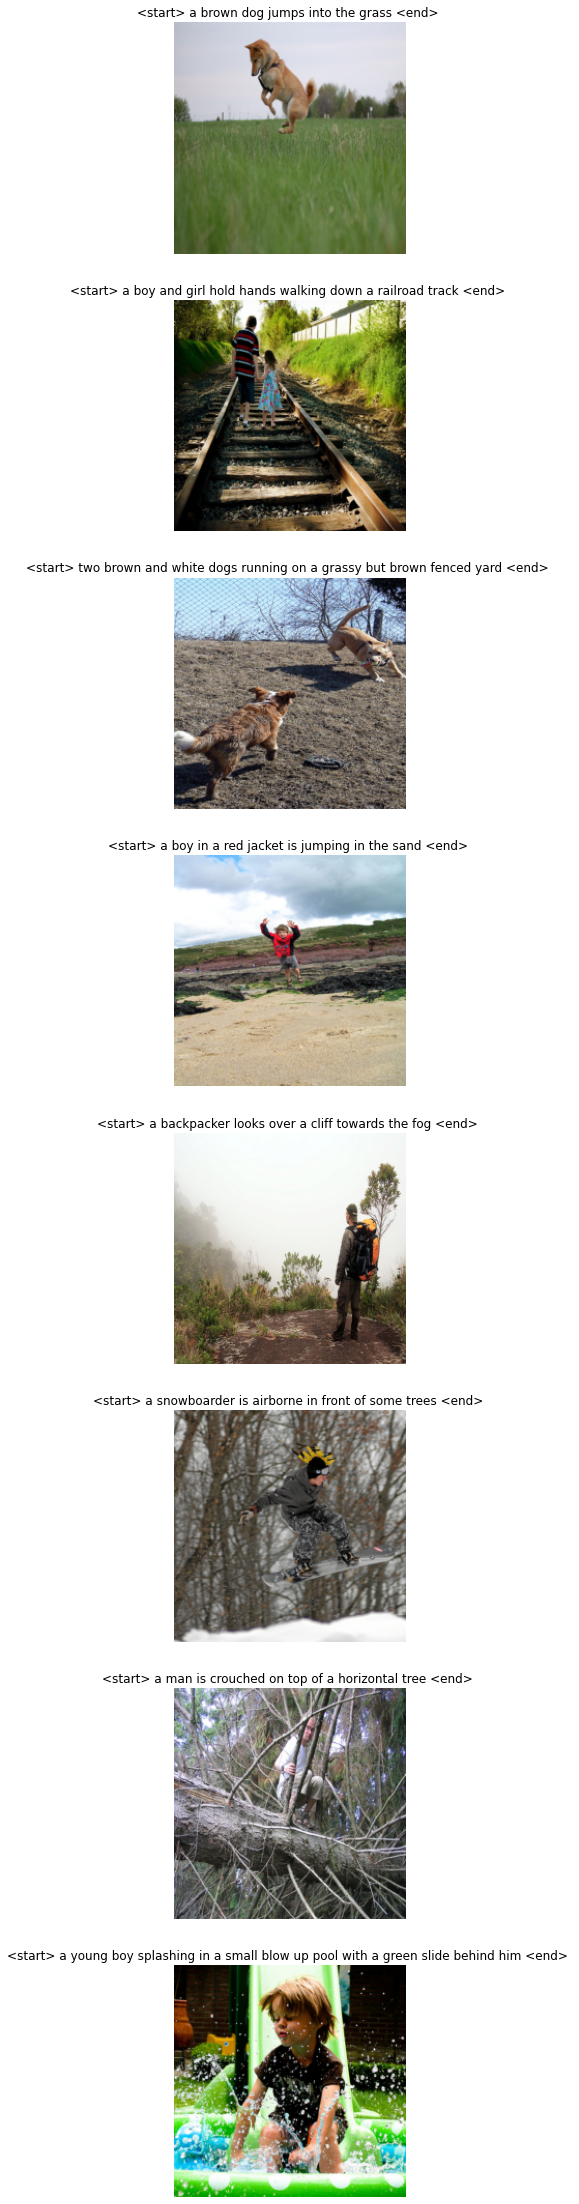

In [9]:
fig, ax = plt.subplots(8, 1, figsize=(40,40))
for i in range(8):
    img = denormalize(np.array(data[0][i]), mean, std)
    ax[i].set_title(get_caption_back(data[1][i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()

# Models exploration
<br>

#### BASELINE:
- Very simple Encoder-Decoder
- Encoder --> CNN (Pretrained backbone)
- Decoder --> RNN, GRU, LSTM (choices)


In [10]:
import torchvision.models as models

In [11]:
# Backbone
# Pretrained model is our choices.
effnet = models.efficientnet_b0(pretrained=True)

In [12]:
# Remove top classifier layer
modules = list(effnet.children())[:-1]
modules

[Sequential(
   (0): ConvNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): ConvNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): ConvNormActivation(
           (0): Conv2d(32, 16, kernel_size=(1, 1)

In [13]:
from source.model import Encoder, Decoder

In [14]:
# Test model
latent_size = 128
hidden_layer = 512
vocab_size = 10000
encoder = Encoder(effnet, effnet.classifier[1].in_features, latent_size).cuda()
decoder = Decoder(latent_size, hidden_layer, 1, vocab_size).cuda()

A:\Users\anaconda3\envs\pattern\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [15]:
x = encoder(data[0].cuda())
out = decoder(x, data[1].cuda())

In [16]:
# OUTPUT

# Batch, Captionlength, Vocabsize
# To extract caption, get highest scores from vocab list for each sequence
# torch.argmax(out, dim=2)
# Then remap with dictionary
out.shape

torch.Size([32, 42, 10000])

In [20]:
# Test Inference function --> Stop teacher forcing 
# Current state of implementation only batch_size=1 is allowed for inference.
val_data = next(iter(val_loader))

In [21]:
encoder.eval()
decoder.eval()
x = encoder(val_data[0].cuda())
# At inference time, input should be only img latent.
out = decoder.inference(x)

In [22]:
# output is token of word
out

[3849,
 6586,
 968,
 4091,
 7599,
 6578,
 3020,
 4891,
 42,
 6927,
 9690,
 9355,
 7869,
 8361,
 9957]